In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from joblib import  load
from deepface import DeepFace

In [2]:
# Define Training dataset
# horizontal_flip = True
#   - Randomly flip images horizontally
# rescale = 1 / 255.0
#   - Rescale the image by 1 / 255.0
# flow_from_directory: 

train_dir = 'images/train'
Train_Data = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    rescale = 1 / 255.0,
).flow_from_directory(
    train_dir, 
    batch_size = 16, 
    subset = "training", 
    target_size = (224, 224), # resize image to `224 x 224`
    shuffle = False 
)


Found 4000 images belonging to 4 classes.


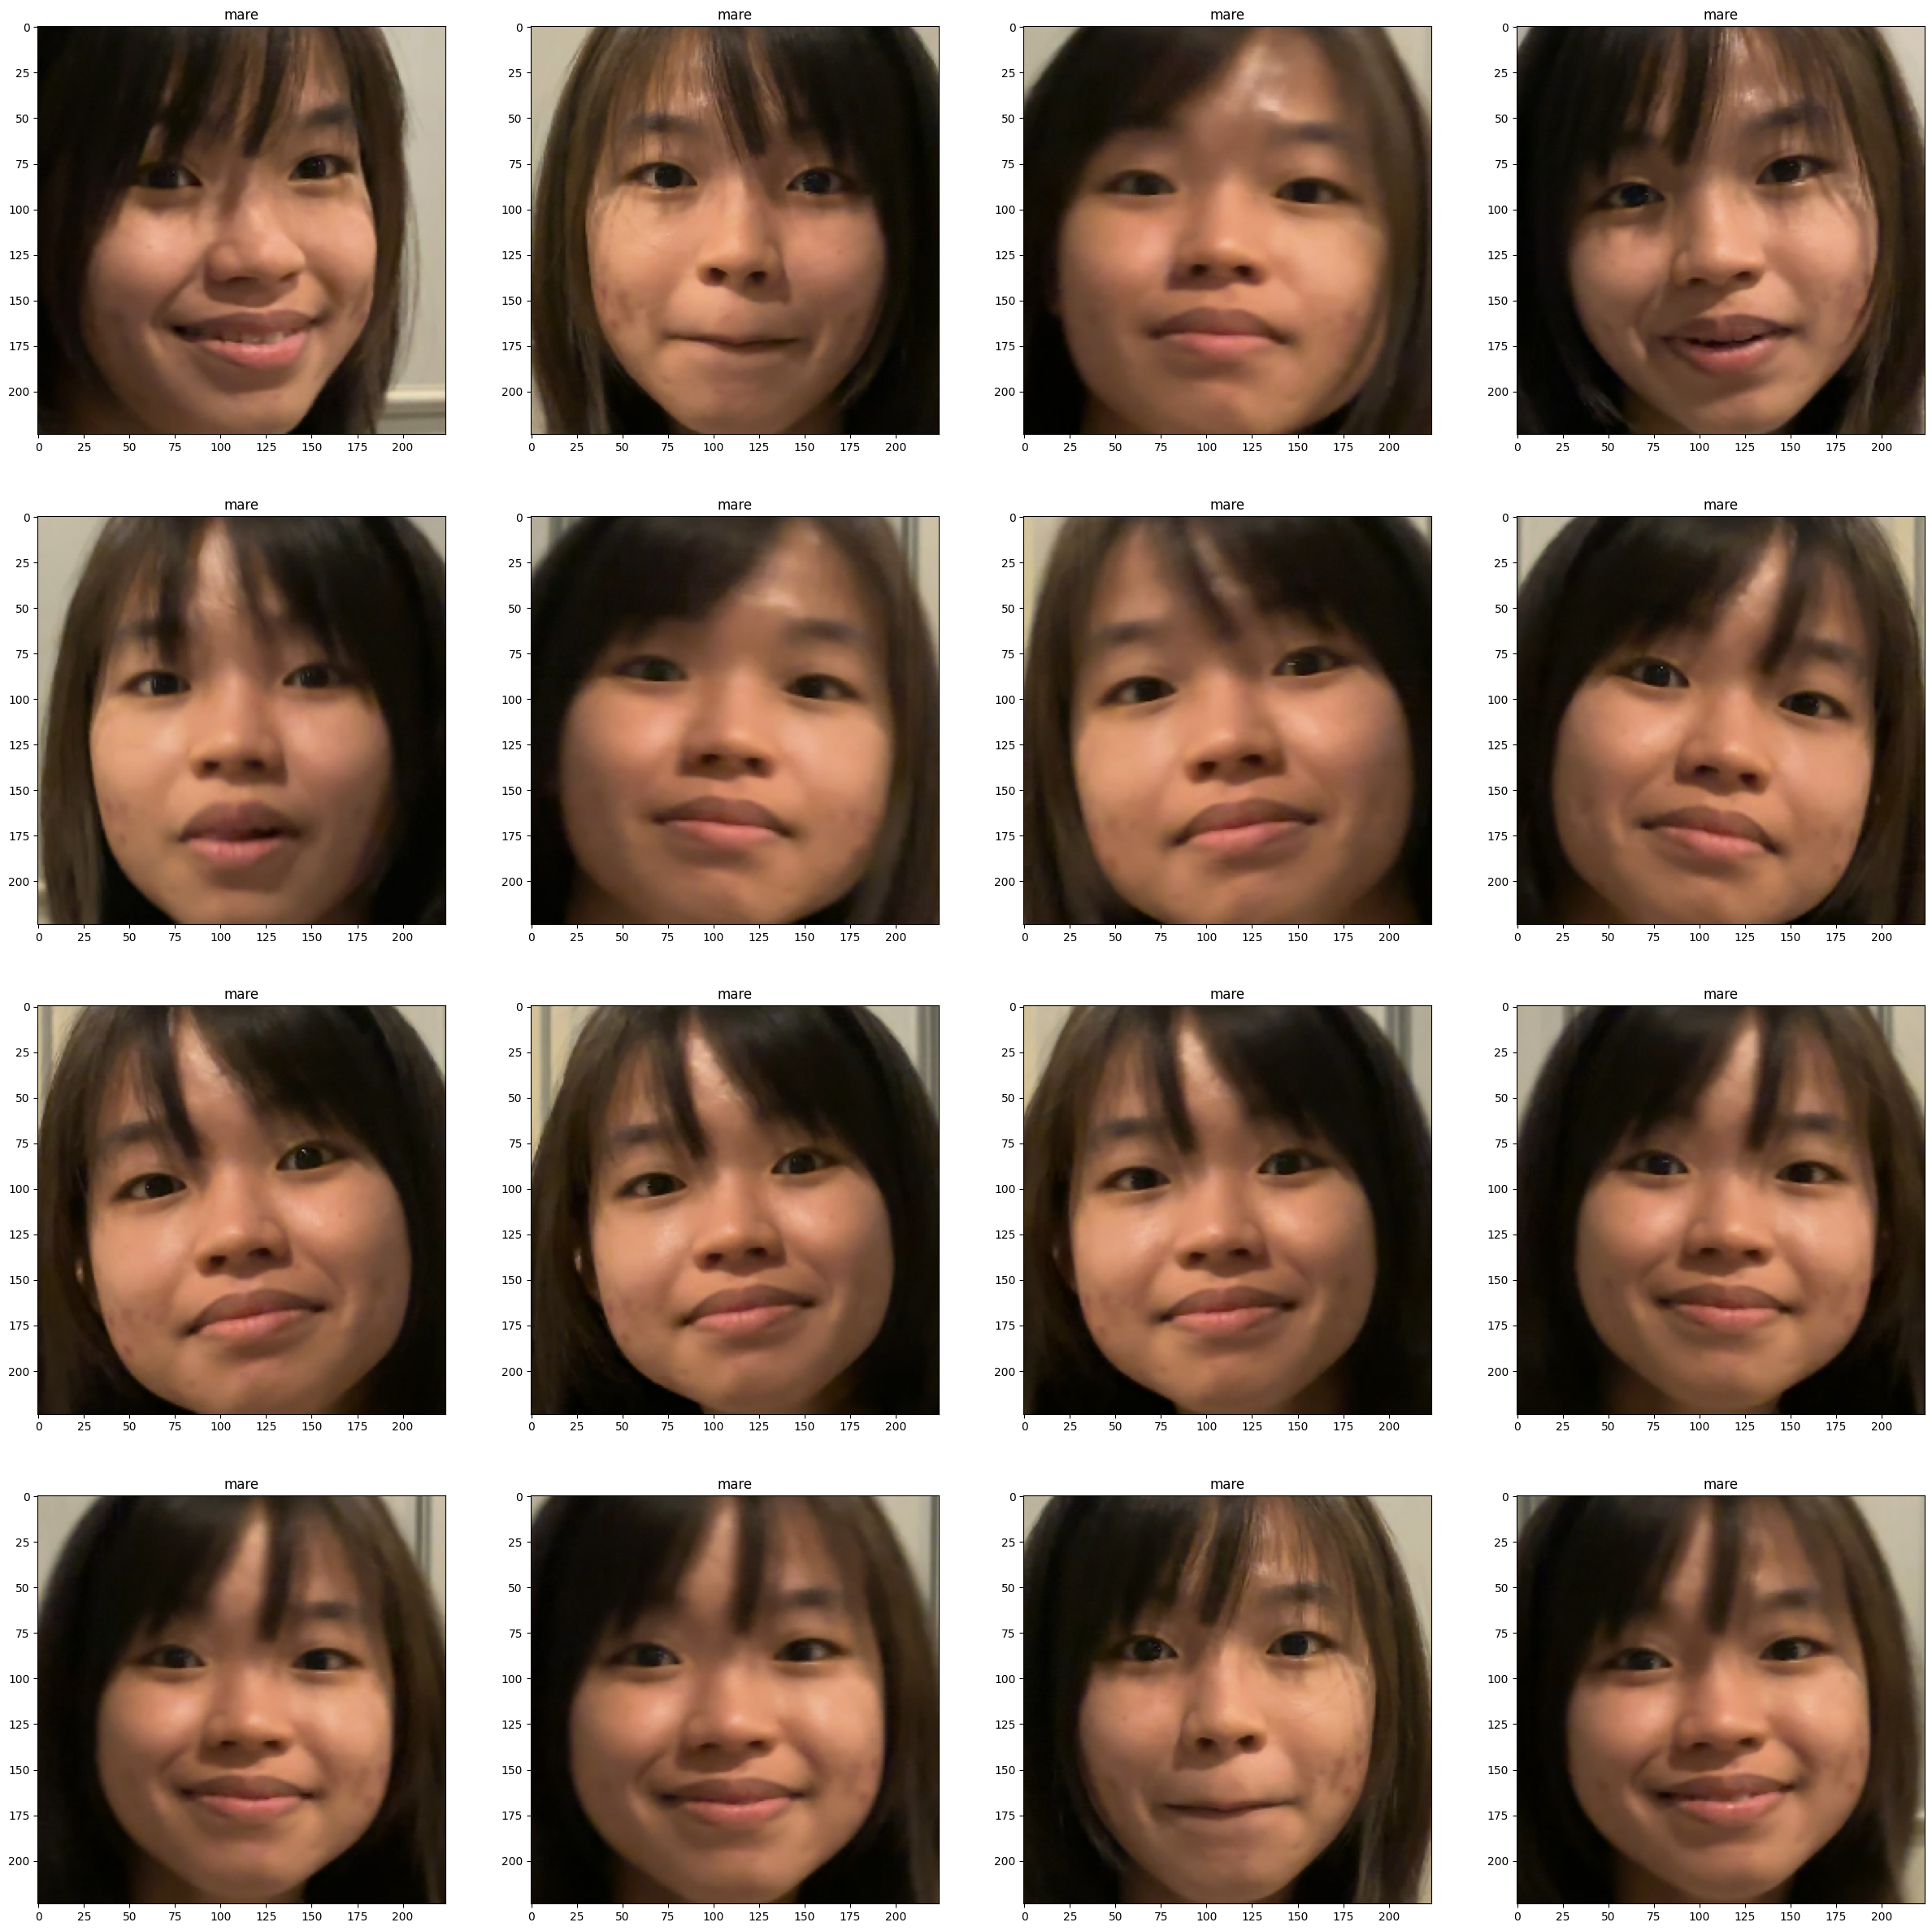

In [3]:
# Display the first 16 images from the training dataset
classes = list(Train_Data.class_indices.keys()) 
plt.figure(figsize=(30, 30))

# Iterate over batches of images and labels in the training dataset
for X_batch, y_batch in Train_Data: 
    # Iterate over the first 16 samples in the batch
    for i in range(0, 16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i] == 1)[0][0]])
    plt.show()
    break


In [4]:
def verifyFaceWithDeepface(image_path):
    dir_path = 'images/euclidean'
    contents = os.listdir(dir_path)
    verified_list = {}
    
    for item in contents:
        file_path = os.path.join(dir_path, item)
        if os.path.exists(file_path):        
            verifying = DeepFace.verify(image_path, file_path, enforce_detection=False)
            if verifying['verified']:
                if item not in verified_list:
                    verified_list[item] = [0, 0]  # Initialize the list with two values
                verified_list[item][0] = 1 - verifying['distance']
                # print(verifying['facial_areas'])
                verified_list[item][1] = verifying['facial_areas']['img1']
                
    if len(verified_list) > 0:
        max_accuracy_class = max(verified_list, key=lambda k: verified_list[k][0])
        max_accuracy = verified_list[max_accuracy_class][0]
        position = verified_list[max_accuracy_class][1]
        
        class_name = max_accuracy_class.split('.')[0]
        # print(class_name, max_accuracy, position)
        return class_name, max_accuracy, position
    else:
        accuracy = verifying['distance']
        position = verifying['facial_areas']['img1']
        return 'unidentify', accuracy, position    

In [ ]:
# Only Detect Face
import time
import cv2
import numpy as np
from facenet_pytorch import MTCNN

# Define the start time
start_time = time.time()

mtcnn = MTCNN(
    image_size=160,  # The size of the image : 160 x 160
    margin=14,  # Margin around the bounding box
    min_face_size=20,  # Minimum face size
    device='cpu',
    post_process=False
)

cap = cv2.VideoCapture('videos/2.mov')
size = (1600, 1200)  # Size of the frame
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, size[1])  # height of the frame
cap.set(cv2.CAP_PROP_FRAME_WIDTH, size[0])  # width of the frame

result_video = cv2.VideoWriter(
    'detecting-face.avi', # Name of the video file
    cv2.VideoWriter_fourcc(*'MJPG'), 
    30,  # Frames per second
    size,  # Size of the frame
)

font = cv2.FONT_HERSHEY_SIMPLEX  # Font style
fontScale = 1  # Font scale
color = (255, 0, 0)  # Font color
thickness = 2  # Font thickness

# Read until video is completed
while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    if not ret:  # If the frame is not read then break the loop
        break

    frame = cv2.resize(frame, (1600, 1200), interpolation=cv2.INTER_CUBIC)  # Resize the frame to 1600 x 1200

    boxes, probs = mtcnn.detect(frame)  # Detect faces in the frame: boxes and probabilities

    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi = frame[y1:y2, x1:x2]  # Region of interest: face
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)  # Draw a rectangle around the face

    result_video.write(frame)  # Write the frame to the video file
    cv2.imshow('frame', frame)  # Display the frame

    if cv2.waitKey(10) & 0xFF == ord('q'):  # If 'q' is pressed then break the loop
        break

    # Check if more than 1 minute has elapsed
    if time.time() - start_time > 60:
        break

cap.release()  # Release the video capture object
result_video.release()  # Release the video writer object
cv2.destroyAllWindows()  # Close all the frames


In [5]:
# Detect faces with MTCNN and recognize them with DeepFace
# With ROI buffered
import time
import cv2
import numpy as np
from facenet_pytorch import MTCNN

# Define the start time
start_time = time.time()

mtcnn = MTCNN(
    image_size=160,  # The size of the image : 160 x 160
    margin=14,  # Margin around the bounding box
    min_face_size=20,  # Minimum face size
    device='cpu',
    post_process=False
)

cap = cv2.VideoCapture('videos/1.mov')
size = (1600, 1200)  # Size of the frame
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, size[1])  # height of the frame
cap.set(cv2.CAP_PROP_FRAME_WIDTH, size[0])  # width of the frame

result_video = cv2.VideoWriter(
    'recognizing_face.avi', # Name of the video file
    cv2.VideoWriter_fourcc(*'MJPG'), # Codec
    30, # Frames per second
    size, # Size of the frame
)

font = cv2.FONT_HERSHEY_SIMPLEX  # Font style
fontScale = 1 # Font scale
color = (255, 0, 0) # Font color
thickness = 2  # Font thickness
frame_count = 0

frame_skip_count = 0
frame_skip_interval = 20

buffer_path = 'buffer/roi/'

# Read until video is completed
while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    frame_count += 1
    frame_skip_count += 1
    
    if frame_skip_count < frame_skip_interval:
        continue
    else:
        frame_skip_count = 0
    
    if not ret:  # If the frame is not read then break the loop
        break
    
    frame = cv2.resize(frame, (1600, 1200), interpolation=cv2.INTER_CUBIC)  # Resize the frame to 1600 x 1200

    boxes, probs = mtcnn.detect(frame)  # Detect faces in the frame: boxes and probabilities

    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi = frame[y1:y2, x1:x2]  # Region of interest: face

            # Check if ROI dimensions are valid
            if roi.shape[0] < 1 or roi.shape[1] < 1:  
                continue
            
            # Save the ROI to a file
            cv2.imwrite(f'{buffer_path}{frame_count}.png', roi) 
            face_class, accuracy, position = verifyFaceWithDeepface('roi.png')
            
            if face_class == 'unidentify':
                blur_roi = cv2.GaussianBlur(roi, (99, 99), 30)
                frame[y1:y2, x1:x2] = blur_roi
            
            cv2.putText(frame, face_class, (x1-5, y1-5), font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(frame, str(np.round(accuracy, 2)), (x2, y2-10), font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)  # Draw a rectangle around the face
            
    result_video.write(frame)  # Write the frame to the video file
    cv2.imshow('frame', frame)  # Display the frame

    if cv2.waitKey(2) & 0xFF == ord('q'):  # If 'q' is pressed then break the loop
        break

    # Check if more than 1 minute has elapsed
    # if time.time() - start_time > 60:
    #     break
print(frame_count)
cap.release()  # Release the video capture object
result_video.release()  # Release the video writer object
cv2.destroyAllWindows()  # Close all the frames


KeyboardInterrupt: 

In [7]:
# Detect faces with MTCNN and recognize them with DeepFace
import time
import cv2
import numpy as np
from facenet_pytorch import MTCNN

# Define the start time
start_time = time.time()

mtcnn = MTCNN(
    image_size=160,  # The size of the image : 160 x 160
    margin=14,  # Margin around the bounding box
    min_face_size=20,  # Minimum face size
    device='cpu',
    post_process=False
)

cap = cv2.VideoCapture('videos/5.mp4')
size = (1600, 1200)  # Size of the frame
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, size[1])  # height of the frame
cap.set(cv2.CAP_PROP_FRAME_WIDTH, size[0])  # width of the frame

result_video = cv2.VideoWriter(
    'recognizing_face.avi', # Name of the video file
    cv2.VideoWriter_fourcc(*'MJPG'), # Codec
    10, # Frames per second
    size, # Size of the frame
)

font = cv2.FONT_HERSHEY_SIMPLEX  # Font style
fontScale = 1 # Font scale
color = (255, 0, 0) # Font color
thickness = 2  # Font thickness
frame_count = 0

frame_skip_count = 0
frame_skip_interval = 20

# Read until video is completed
while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    frame_count += 1
    frame_skip_count += 1
    
    if frame_skip_count < frame_skip_interval:
        continue
    else:
        frame_skip_count = 0
    
    if not ret:  # If the frame is not read then break the loop
        break
    
    frame = cv2.resize(frame, (1600, 1200), interpolation=cv2.INTER_CUBIC)  # Resize the frame to 1600 x 1200

    boxes, probs = mtcnn.detect(frame)  # Detect faces in the frame: boxes and probabilities

    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi = frame[y1:y2, x1:x2]  # Region of interest: face

            # Check if ROI dimensions are valid
            if roi.shape[0] < 1 or roi.shape[1] < 1:  
                continue
            
            # Save the ROI to a file
            cv2.imwrite('roi.png', roi)
            face_class, accuracy, position = verifyFaceWithDeepface('roi.png')
            
            if face_class == 'unidentify':
                blur_roi = cv2.GaussianBlur(roi, (99, 99), 30)
                frame[y1:y2, x1:x2] = blur_roi
            
            cv2.putText(frame, face_class, (x1-5, y1-5), font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(frame, str(np.round(accuracy, 2)), (x2, y2-10), font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)  # Draw a rectangle around the face
            
    result_video.write(frame)  # Write the frame to the video file
    cv2.imshow('frame', frame)  # Display the frame

    if cv2.waitKey(2) & 0xFF == ord('q'):  # If 'q' is pressed then break the loop
        break

    # Check if more than 1 minute has elapsed
    # if time.time() - start_time > 60:
    #     break
print(frame_count)
cap.release()  # Release the video capture object
result_video.release()  # Release the video writer object
cv2.destroyAllWindows()  # Close all the frames

280
